- 기본 경사하강법은 전체 데이터를 사용하여 기울기를 계산함 -> 시간이 많이 걸림
- 단점 보완 -> 데이타의 일부만 사용

### 데이터 셋(N)이 클 경우
- 문제점1 : 한번에 처리가 안됨 (모든 데이터로 학습을 시킬 수 없음, GPU의 메모리 문제로 일괄처리 어려움)
- 문제점2 : 학습속도가 느림 (한번의 파라미터 업데이트를 위해 전체 데이터를 feed-forwaard 시키는 것은 비효율적)

## 확률적 경사하강법
- 전체 데이터 셋에서 랜덤 샘플링한 k개의 샘플만 feed-forward 시킴
  - 단, 샘플링에서 데이터가 중복해서 들어가지 않도록 반드시 비복원 추출을 수행해야 함
- 샘플링한 k개의 샘플 묶음을 미니배치하고 함
- 전체 데이터를 한번씩 feed-forward 하는 것을 1 에폭 이라고 함
- 하나의 미니배치를 feed-forward 하는 것을 이터레이션 이라고 함
- 1 에폭 동안 파라미터를 업데이트(이터레이션) 하는 횟수
   - N/K번

## 실습: SGD 적용하기

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [4]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns = california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [6]:
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

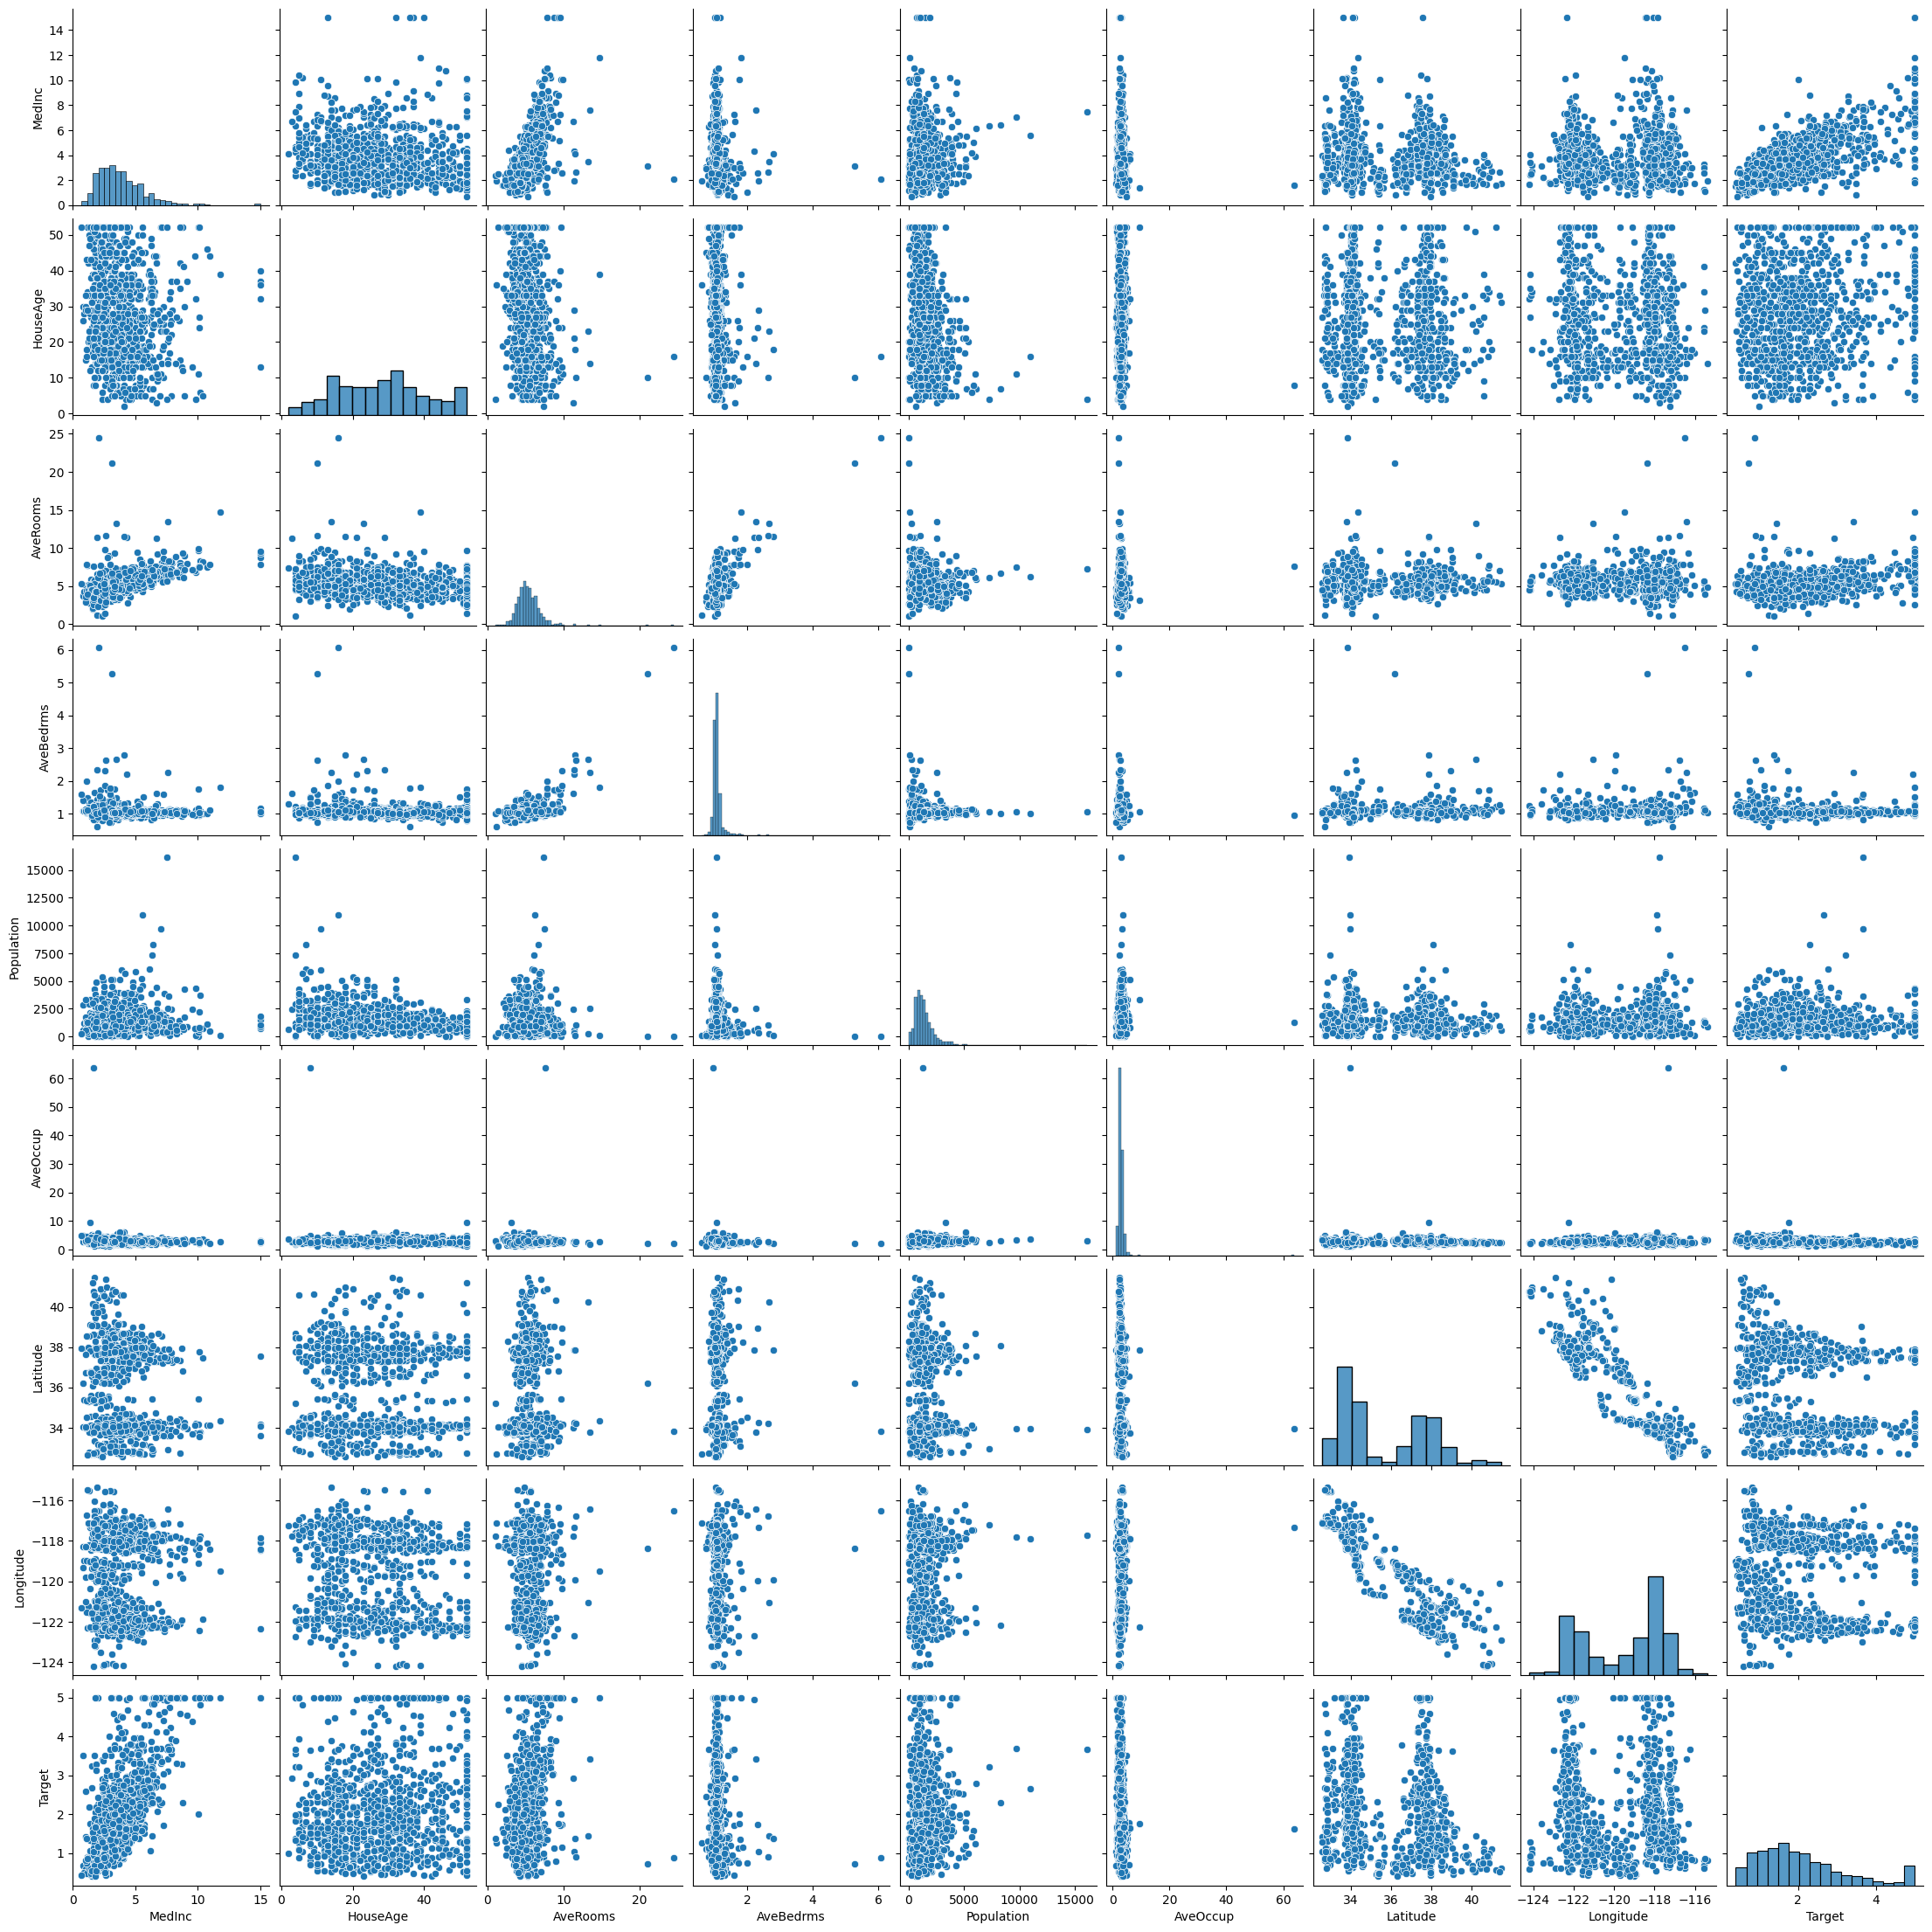

In [5]:
sns.pairplot(df.sample(1000))
plt.show()

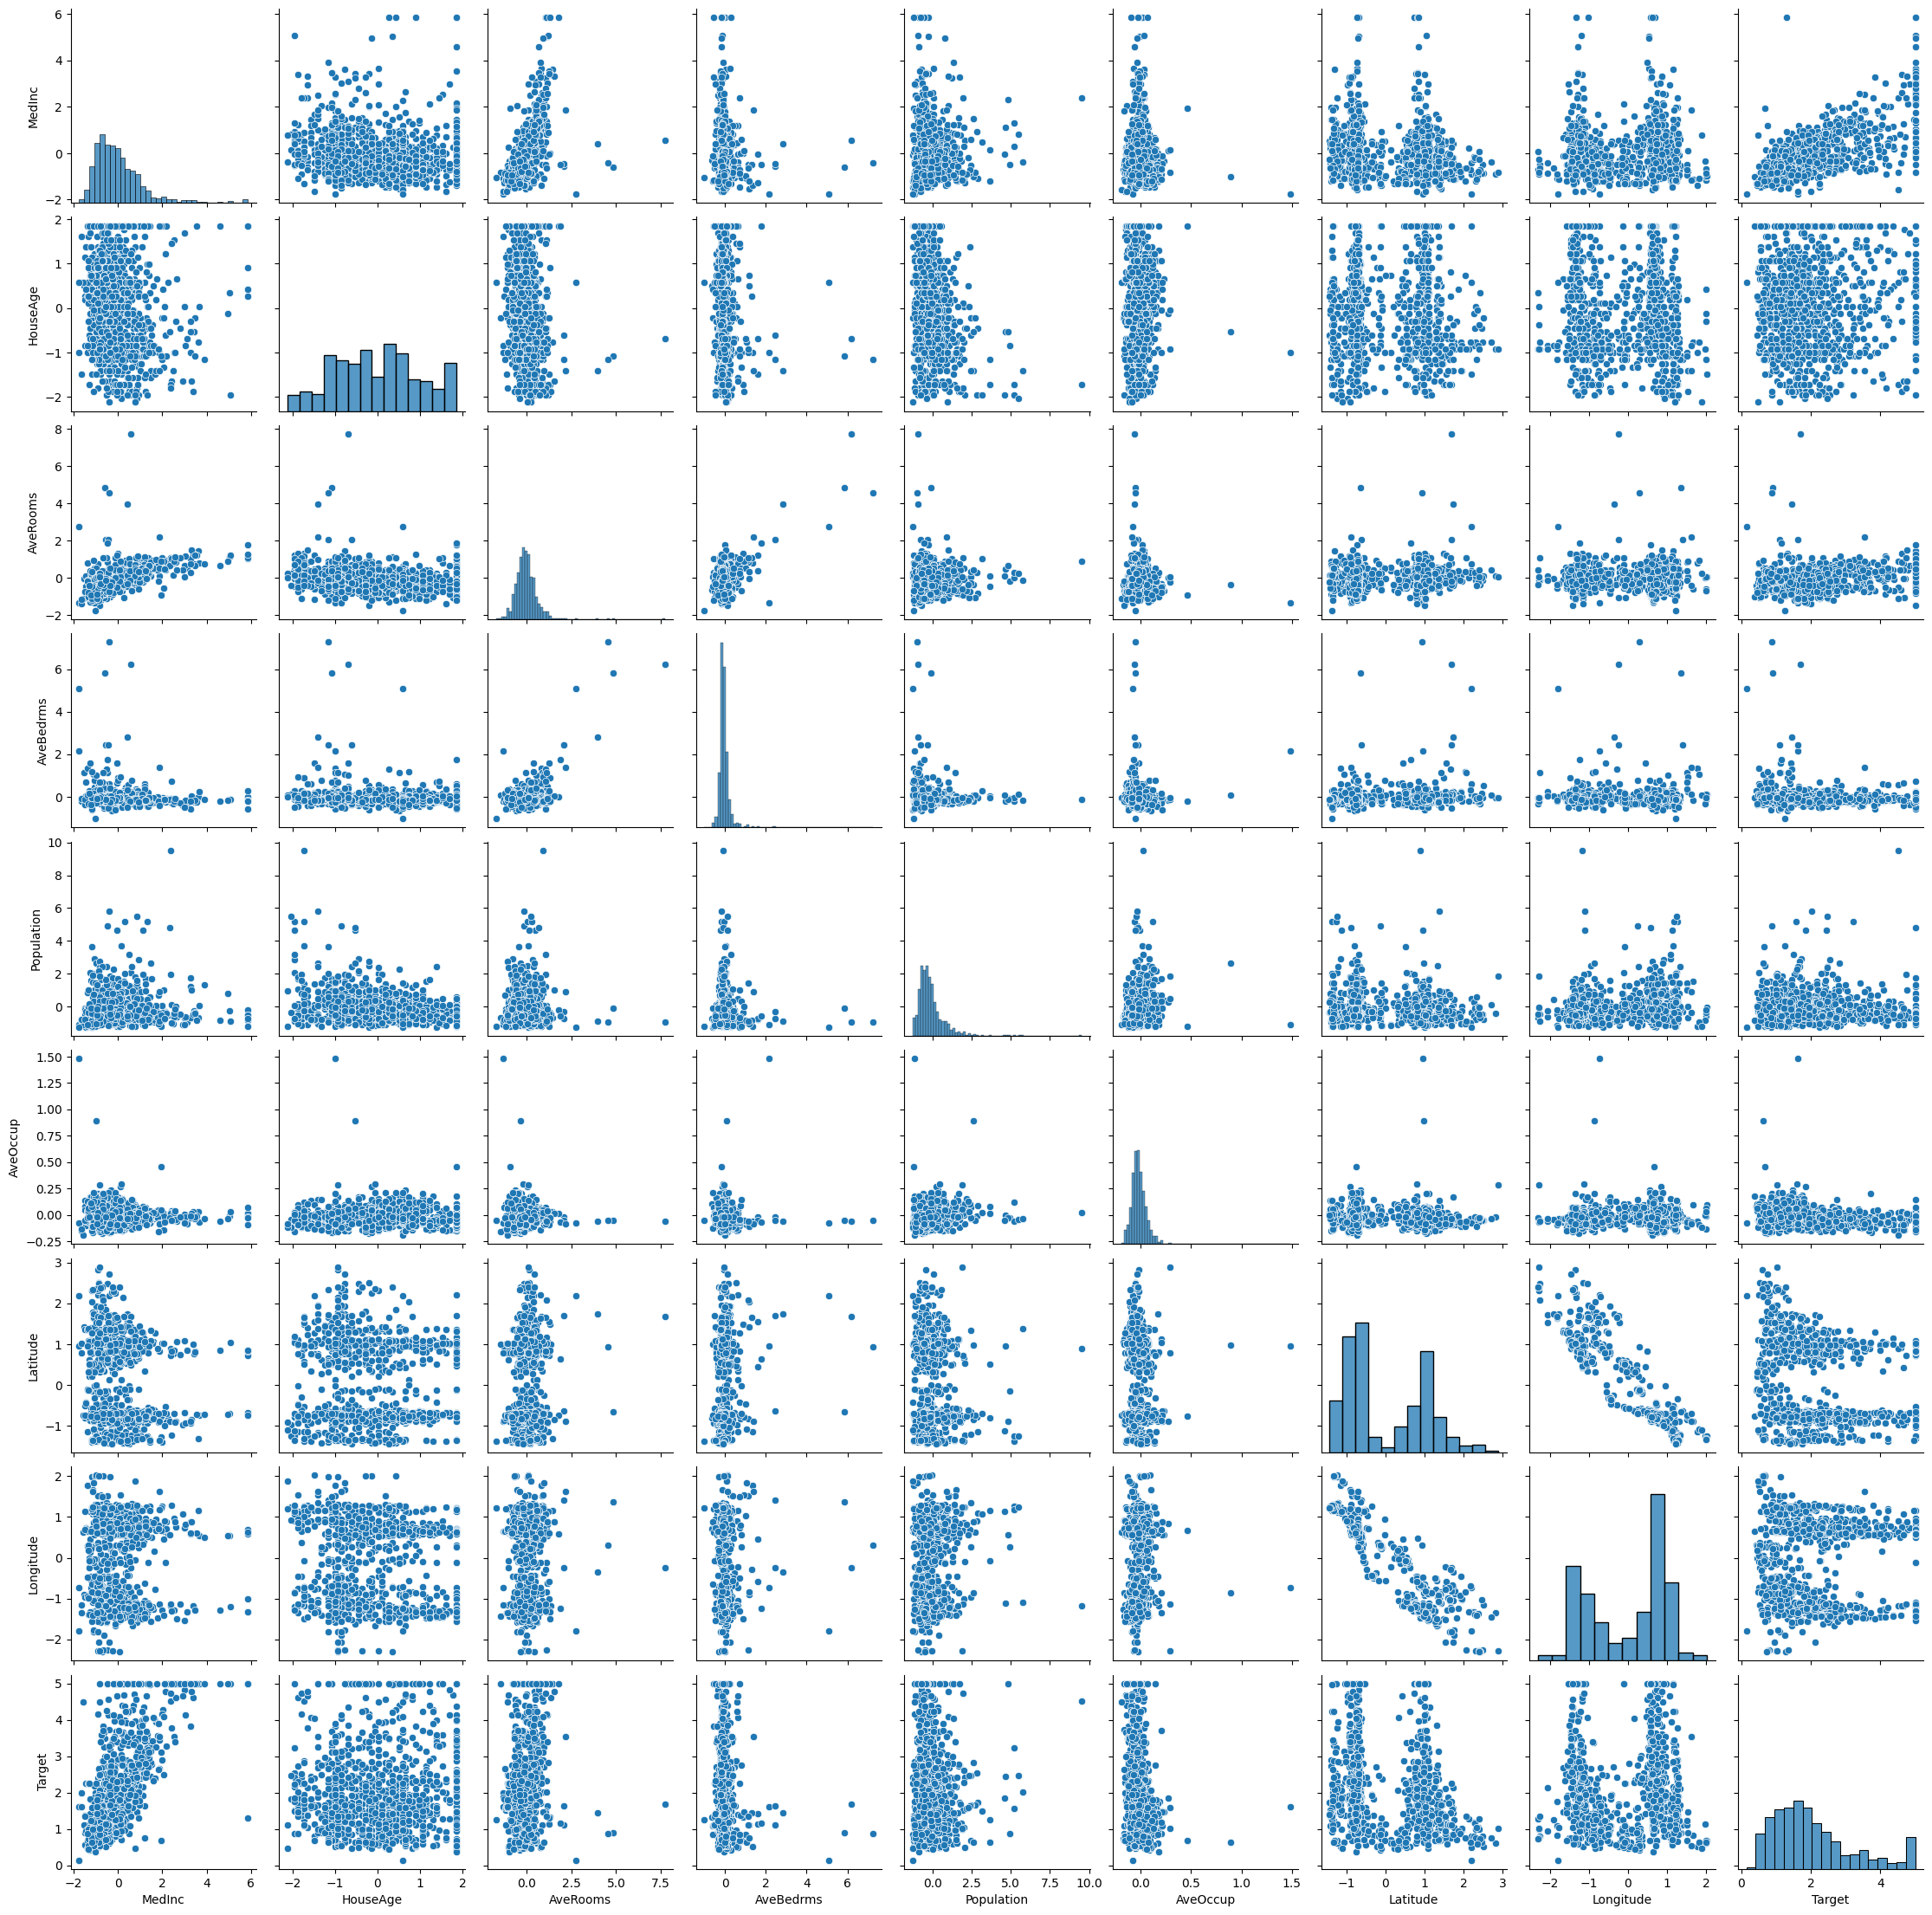

In [7]:
# 데이터 정규화
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.iloc[:,:-1] = scaler.transform(df.values[:,:-1]).round(4)

sns.pairplot(df.sample(1000))
plt.show()

In [8]:
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,-1.2161,-0.2892,-0.1550,0.0774,-0.5126,-0.0491,1.8016,-0.7588,0.781
20636,-0.6916,-0.8454,0.2769,0.4624,-0.9444,0.0050,1.8063,-0.8187,0.771
20637,-1.1426,-0.9249,-0.0903,0.0494,-0.3695,-0.0717,1.7782,-0.8237,0.923
20638,-1.0546,-0.8454,-0.0402,0.1588,-0.6044,-0.0912,1.7782,-0.8736,0.847
20639,-0.7801,-1.0043,-0.0704,0.1384,-0.0340,-0.0437,1.7501,-0.8337,0.894


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
data = torch.from_numpy(df.values).float()

print(data.shape)

torch.Size([20640, 9])


In [34]:
x = data[:,:-1]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


## 하이퍼파라미터 설정
### 미내배치 적용
- 배치 사이즈 : 256

In [35]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

### 모델 정의

In [36]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


## 최적화 적용

In [37]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### 학습
- 미니배치를 위해 데이터의 인덱스를 shuffle 시킴

In [38]:
import time
start = time.time()
for i in range(n_epochs):
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss) # 메모리 손실을 없애기 위해

        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)
    if(i+1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

end = time.time()
elapsed = end - start
print('Elapsed time: %dm %ds'%(elapsed//60, int(elapsed - elapsed//60)))

Epoch 200: loss=3.2921e-01
Epoch 400: loss=3.0585e-01
Epoch 600: loss=3.0015e-01
Epoch 800: loss=2.9672e-01
Epoch 1000: loss=2.9408e-01
Epoch 1200: loss=2.9307e-01
Epoch 1400: loss=2.9220e-01
Epoch 1600: loss=2.8963e-01
Epoch 1800: loss=2.8848e-01
Epoch 2000: loss=2.8822e-01
Epoch 2200: loss=2.8793e-01
Epoch 2400: loss=2.8829e-01
Epoch 2600: loss=2.8720e-01
Epoch 2800: loss=2.8697e-01
Epoch 3000: loss=2.8589e-01
Epoch 3200: loss=2.8643e-01
Epoch 3400: loss=2.8590e-01
Epoch 3600: loss=2.8569e-01
Epoch 3800: loss=2.8590e-01
Epoch 4000: loss=2.8504e-01
Elapsed time: 0m 40s


### 결과 확인

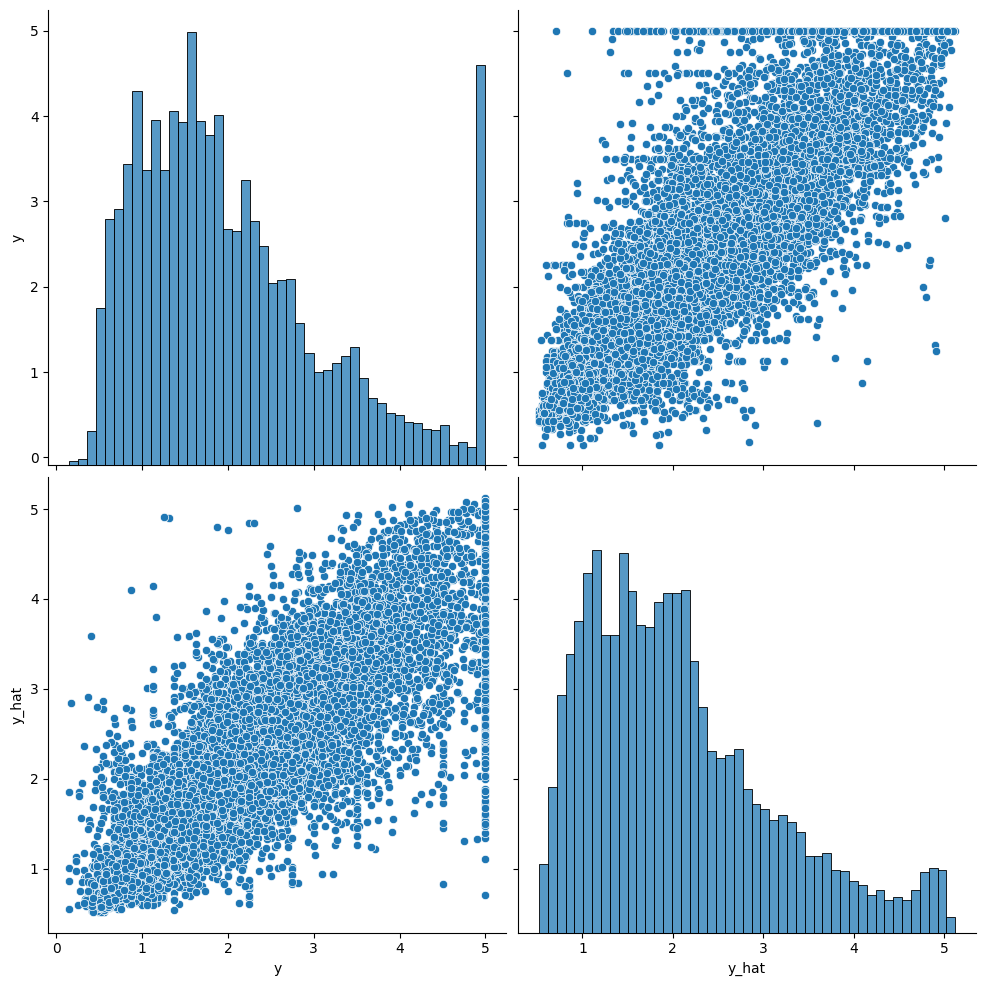

In [39]:
df = pd.DataFrame(torch.cat([y,y_hat], dim=1).detach().numpy(),
                  columns=["y","y_hat"])

sns.pairplot(df, height=5)
plt.show()

In [40]:
print(y.shape)
print(y_hat.shape)

torch.Size([20640, 1])
torch.Size([20640, 1])


# 최적화
## 하이퍼 파라미터
- 모델의 성능에 영향을 끼지치만 자동으로 최적화되지 않는 파라미터
- 실험을 통해 사람이 튜닝해여 함
- 종류
  - 학습률
  - 미니배치 크기
  - 에폭의 수
  - 신경망의 깊이와 너비
  - 활성함수의 종류

## 적응형 학습률
- 기본 : SGD
  - 처음 하이퍼파라미터로 정한 학습률로 끝까지 학습시킴
- 모멘텀
  - 시작부터 매번 계산된 그레디언트를 누적 -> 관성의 개념 적용
  - 문제점 : 처음 학습률의 크기가 최적화에 영향
- 적응형 학습률 -> 자동으로 학습률 조정
  - 학습률 스케줄링
    - 초기에 큰 학습률 -> 점차적으로 학습률을 감쇠시킴
    - 문제점 : 감쇠를 위한 하이퍼파라미터가 필요함
  - 아다그래드(AdaGrad)
    - 가중치마다 다른 학습률 적용
    - 가중치 파라미터가 업데이트 될수록 반비례하여 학습률이 작아짐
    - 문제점 : 업데이트가 많이 된 후에는 학습률이 너무 작아져서 학습이 안됨
  - 아담(Adam)
    - 적응형 + 모멘텀 : 가존 방식의 단점들을 보완

## 실습: 아담 옵티마이저 적용하기

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

df = pd.DataFrame(california.data, columns = california.feature_names)
df["Target"] = california.target
df.tail()

# 데이터 정규화
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.iloc[:,:-1] = scaler.transform(df.values[:,:-1]).round(4)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()

x = data[:,:-1]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [41]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

In [42]:
optimizer = optim.Adam(model.parameters())

In [45]:
import time
start = time.time()
for i in range(n_epochs):
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss) # 메모리 손실을 없애기 위해

        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)
    if(i+1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

end = time.time()
elapsed = end - start
print('Elapsed time: %dm %ds'%(elapsed//60, int(elapsed - elapsed//60)))

Epoch 200: loss=1.3270e+00
Epoch 400: loss=1.3254e+00
Epoch 600: loss=1.3254e+00
Epoch 800: loss=1.3253e+00
Epoch 1000: loss=1.3235e+00
Epoch 1200: loss=1.3251e+00
Epoch 1400: loss=1.3250e+00
Epoch 1600: loss=1.3246e+00
Epoch 1800: loss=1.3247e+00
Epoch 2000: loss=1.3254e+00
Epoch 2200: loss=1.3240e+00
Epoch 2400: loss=1.3258e+00
Epoch 2600: loss=1.3251e+00
Epoch 2800: loss=1.3242e+00
Epoch 3000: loss=1.3243e+00
Epoch 3200: loss=1.3254e+00
Epoch 3400: loss=1.3233e+00
Epoch 3600: loss=1.3243e+00
Epoch 3800: loss=1.3238e+00
Epoch 4000: loss=1.3226e+00
Elapsed time: 1m 67s


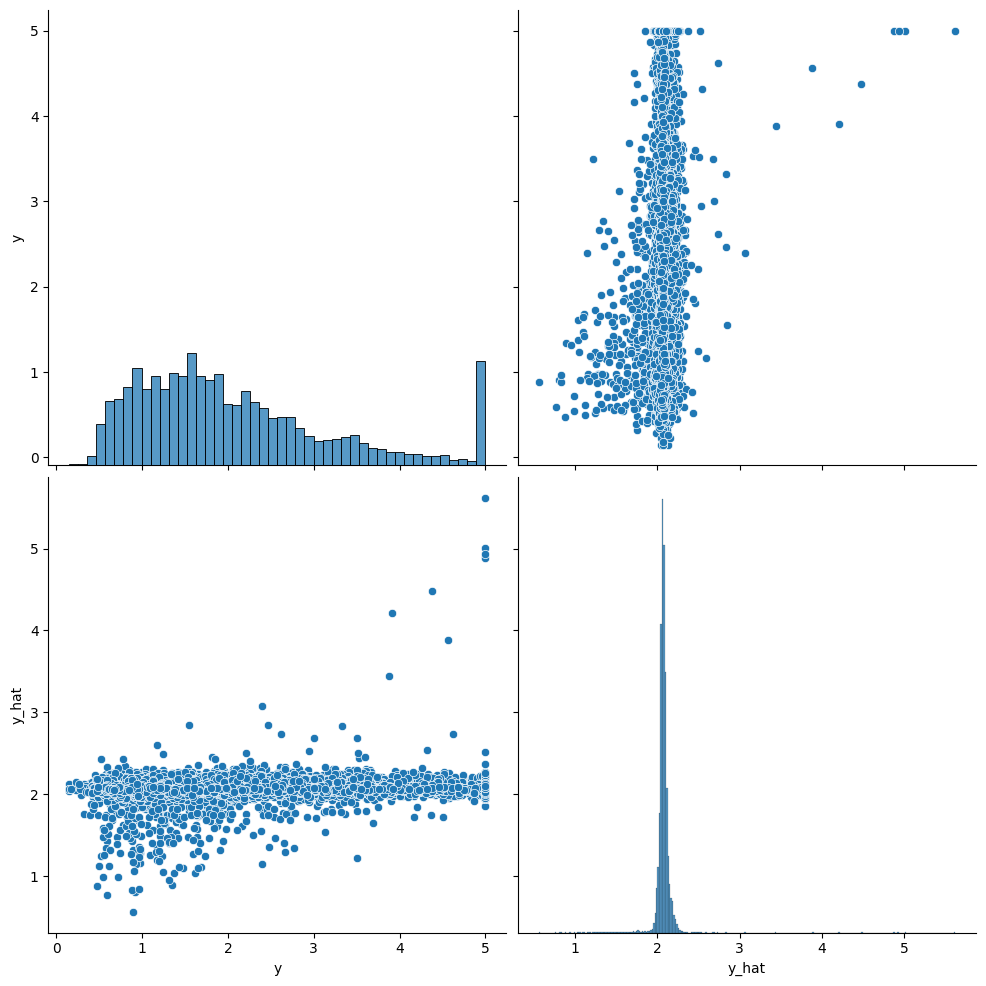

In [46]:
df = pd.DataFrame(torch.cat([y,y_hat], dim=1).detach().numpy(),
                  columns=["y","y_hat"])

sns.pairplot(df, height=5)
plt.show()